In [1]:
!nvidia-smi

Fri Jul 16 21:50:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install albumentations==0.4.6

In [3]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

In [5]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [6]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [7]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [8]:
mean = m/255
sdev = s/255

mean, sdev

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [9]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [10]:
class GaussNoise(object):
    def __init__(self, mean=0, sdev=1.0):
        self.sdev = sdev
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor, dtype=tensor.dtype, device=tensor.device) * tensor.new(self.sdev) + tensor.new(self.mean)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, sdev={1})'.format(self.mean, self.sdev)


In [11]:
criterion = nn.CrossEntropyLoss()
noise = GaussNoise(mean=mean, sdev=sdev)

In [12]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None, grad_clip=None):
    scaler = torch.cuda.amp.GradScaler()

    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info
    # revert = None
    for epoch in range(epochs):
      correct = processed = train_loss = 0
      
    #   if epoch == 1:
    #       revert = torch.rand_like(revert, requires_grad=True)

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops
          
          with torch.cuda.amp.autocast():
            output = model(data) # get the model's predictions

            loss = criterion(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

        #   if epoch == 0:
        #       revert = loss
        #       train_loss += loss.item()
        #   else:
        #   train_loss += (noise(loss)).item()
          train_loss += loss.item()

          scaler.scale(loss).backward()
        #   loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          if grad_clip: 
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        #   optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size
          
          scaler.step(optimizer)
          scaler.update()
          
          if scheduler:
            # print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
            scheduler.step()

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

        

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += criterion(output, target).sum().item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [13]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [14]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [35]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.augmentations.transforms.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_REFLECT_101,
                                                                       p=0.5),
                              A.RandomCrop(32, 32),
                              A.HorizontalFlip(p=0.5),
                            #   A.Cutout(num_holes=1, max_h_size=8,max_w_size=8,fill_value=mean, p=0.3),
                                # A.ShiftScaleRotate(shift_limit=0.14,scale_limit=0.15,rotate_limit=30,p=0.24),
                                A.CoarseDropout(max_holes=1, p=0.1, max_height=8,
                                                max_width=8, min_holes=1, min_height=8,
                                                min_width=8, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                # A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                    ])


In [36]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


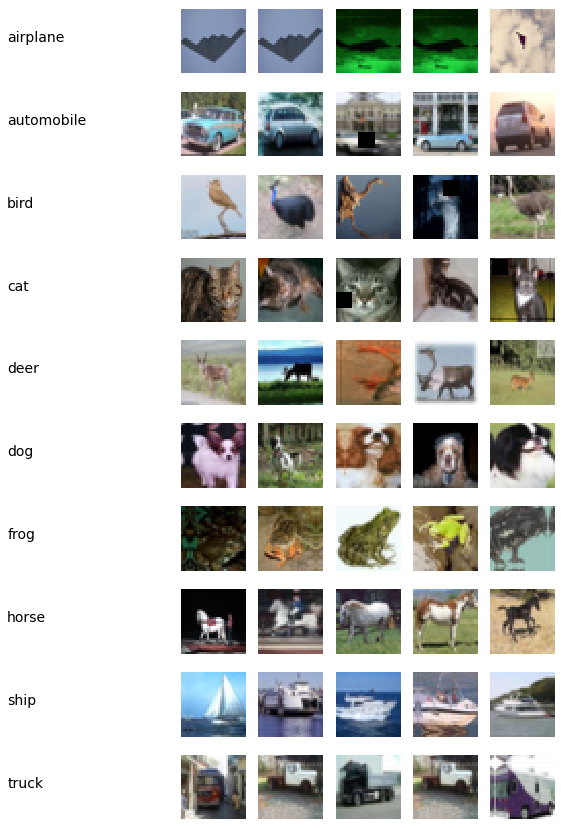

In [37]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [38]:
# def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#               nn.BatchNorm2d(out_channels), 
#               nn.ReLU(inplace=True)]
#     if max_pool:
#         layers.append(nn.MaxPool2d(2))
    
#     return nn.Sequential(*layers)

def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)]
    if max_pool:
        layers.append(nn.MaxPool2d(2))

    layers.extend([nn.BatchNorm2d(out_channels), 
    nn.ReLU(inplace=True)])
    
    
    return nn.Sequential(*layers)

In [39]:
class CustomResNet(nn.Module):
    def __init__(self, in_planes, num_classes):
        super().__init__()
        
        self.conv1 = get_conv_block(in_channels = in_planes, out_channels = 64)
        self.conv2 = get_conv_block(in_channels = 64, out_channels = 128, max_pool=True)
        self.res1 = nn.Sequential(get_conv_block(in_channels=128, out_channels=128),
                                  get_conv_block(in_channels=128, out_channels=128))
        
        self.conv3 = get_conv_block(128, 256, max_pool=True)
        self.conv4 = get_conv_block(256, 512, max_pool=True)
        self.res2 = nn.Sequential(get_conv_block(512, 512),
                                  get_conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out + self.res2(out)
        out = self.classifier(out)
        # out = F.softmax(out, dim=-1)
        return out

In [40]:
model = CustomResNet(3, 10).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [41]:
model = CustomResNet(3, 10).to(device)
max_lr = 0.01

optimizer = optim.SGD(model.parameters(), lr = max_lr, momentum=0.9, nesterov=True,weight_decay=1e-4)

# optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                                anneal_strategy='linear',
                                                verbose=False, epochs=24,
                                                steps_per_epoch=len(train_loader),
                                                pct_start=0.3)


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

start = time.perf_counter()

train_eval_model(model, train_loader, optimizer, device, epochs=24, test=True, test_loader=test_loader,scheduler=scheduler, grad_clip=None)

end = time.perf_counter()

print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")

  0%|          | 0/98 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 98/98 [00:14<00:00,  6.69it/s]


			Train metrics: accuracy: 20409/50000 (40.8180%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 5637/10000 (56.37000%)


 epoch num ================================= 2


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


			Train metrics: accuracy: 22347/50000 (44.6940%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0025, accuracy: 5576/10000 (55.76000%)


 epoch num ================================= 3


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 29656/50000 (59.3120%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0027, accuracy: 5440/10000 (54.40000%)


 epoch num ================================= 4


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


			Train metrics: accuracy: 33004/50000 (66.0080%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0016, accuracy: 7173/10000 (71.73000%)


 epoch num ================================= 5


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


			Train metrics: accuracy: 35834/50000 (71.6680%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0015, accuracy: 7313/10000 (73.13000%)


 epoch num ================================= 6


100%|██████████| 98/98 [00:14<00:00,  6.75it/s]


			Train metrics: accuracy: 37258/50000 (74.5160%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0017, accuracy: 7196/10000 (71.96000%)


 epoch num ================================= 7


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


			Train metrics: accuracy: 38690/50000 (77.3800%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0012, accuracy: 7970/10000 (79.70000%)


 epoch num ================================= 8


100%|██████████| 98/98 [00:14<00:00,  6.69it/s]


			Train metrics: accuracy: 40196/50000 (80.3920%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0011, accuracy: 8152/10000 (81.52000%)


 epoch num ================================= 9


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


			Train metrics: accuracy: 41450/50000 (82.9000%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0010, accuracy: 8232/10000 (82.32000%)


 epoch num ================================= 10


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 42485/50000 (84.9700%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0012, accuracy: 8067/10000 (80.67000%)


 epoch num ================================= 11


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 43214/50000 (86.4280%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8409/10000 (84.09000%)


 epoch num ================================= 12


100%|██████████| 98/98 [00:14<00:00,  6.71it/s]


			Train metrics: accuracy: 43891/50000 (87.7820%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8457/10000 (84.57000%)


 epoch num ================================= 13


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 44581/50000 (89.1620%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8493/10000 (84.93000%)


 epoch num ================================= 14


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


			Train metrics: accuracy: 45120/50000 (90.2400%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0010, accuracy: 8421/10000 (84.21000%)


 epoch num ================================= 15


100%|██████████| 98/98 [00:14<00:00,  6.71it/s]


			Train metrics: accuracy: 45658/50000 (91.3160%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0010, accuracy: 8420/10000 (84.20000%)


 epoch num ================================= 16


100%|██████████| 98/98 [00:14<00:00,  6.71it/s]


			Train metrics: accuracy: 46113/50000 (92.2260%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8582/10000 (85.82000%)


 epoch num ================================= 17


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


			Train metrics: accuracy: 46510/50000 (93.0200%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0010, accuracy: 8539/10000 (85.39000%)


 epoch num ================================= 18


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 46857/50000 (93.7140%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0008, accuracy: 8716/10000 (87.16000%)


 epoch num ================================= 19


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 47170/50000 (94.3400%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0008, accuracy: 8694/10000 (86.94000%)


 epoch num ================================= 20


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 47547/50000 (95.0940%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0008, accuracy: 8718/10000 (87.18000%)


 epoch num ================================= 21


100%|██████████| 98/98 [00:14<00:00,  6.72it/s]


			Train metrics: accuracy: 47875/50000 (95.7500%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0008, accuracy: 8773/10000 (87.73000%)


 epoch num ================================= 22


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


			Train metrics: accuracy: 48138/50000 (96.2760%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8776/10000 (87.76000%)


 epoch num ================================= 23


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


			Train metrics: accuracy: 48320/50000 (96.6400%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0009, accuracy: 8814/10000 (88.14000%)


 epoch num ================================= 24


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


			Train metrics: accuracy: 48511/50000 (97.0220%)



	Test metrics: average loss: 0.0008, accuracy: 8834/10000 (88.34000%)



Time taken: 6.0 minutes and 26 seconds


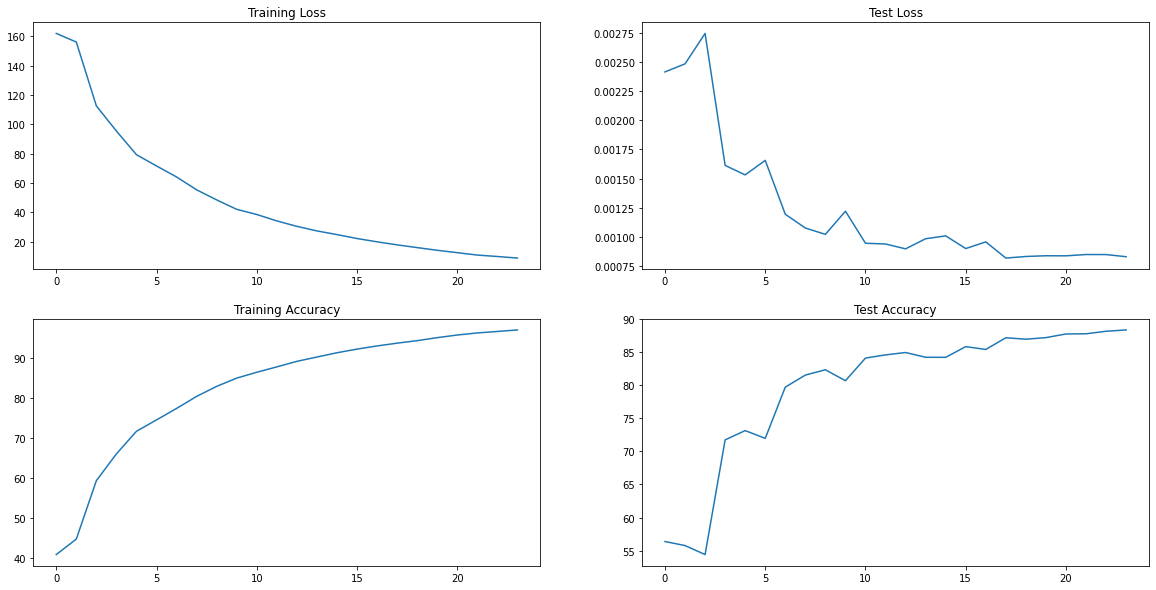

In [42]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    

In [23]:
# import math
# criterion = nn.CrossEntropyLoss()
# # criterion = F.nll_loss
# def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
#     num = len(train_loader)-1
#     mult = (final_value / init_value) ** (1/num)
#     lr = init_value
#     optimizer.param_groups[0]['lr'] = lr
#     avg_loss = 0.
#     best_loss = 0.
#     batch_num = 0
#     losses = []
#     log_lrs = []
#     for data in train_loader:
#         batch_num += 1
#         #As before, get the loss for this mini-batch of inputs/outputs
#         inputs,labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         #Compute the smoothed loss
#         avg_loss = beta * avg_loss + (1-beta) *loss.item()
#         smoothed_loss = avg_loss / (1 - beta**batch_num)
#         #Stop if the loss is exploding
#         if batch_num > 1 and smoothed_loss > 4 * best_loss:
#             return log_lrs, losses
#         #Record the best loss
#         if smoothed_loss < best_loss or batch_num==1:
#             best_loss = smoothed_loss
#         #Store the values
#         losses.append(smoothed_loss)
#         log_lrs.append(math.log10(lr))
#         #Do the SGD step
#         loss.backward()
#         optimizer.step()
#         #Update the lr for the next step
#         lr *= mult
#         optimizer.param_groups[0]['lr'] = lr
#     return log_lrs, losses

In [24]:
# net = model = customResnet().to(device)
# # net = model = Net1().to(device)
# optimizer = optim.SGD(model.parameters(),lr=1e-1)
# logs, losses = find_lr()
# plt.plot(logs,losses)

In [25]:
# !pip install torch-lr-finder
# from torch_lr_finder import LRFinder

In [26]:
# criterion = nn.CrossEntropyLoss()
# # optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, nesterov=True)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=10, num_iter=500)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [27]:
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.95, nesterov=True)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.47e-02, anneal_strategy='linear',
#                                                 verbose=False, epochs=24, steps_per_epoch=len(train_loader),pct_start=0.3)

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# start = time.perf_counter()

# train_eval_model(model, train_loader, optimizer, device, epochs=24, test=True, test_loader=test_loader,scheduler=scheduler)

# end = time.perf_counter()

# print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")